In [ ]:

import gymnasium as gym
import ale_py
from tqdm.notebook import tqdm
from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from collections import deque
from ale_py import ALEInterface, roms
import time
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

ale = ALEInterface()
env = gym.make("MountainCar-v0")

Using device: cuda


In [ ]:

# Trenowana sieć
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym

# Bufor obserwacji/doświadczeń z gier rozegranych przez agenta
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device),
            torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)

# Wrappery do środowiska w celu użycia własnej funkcji nagrody

class CustomRewardEnv_1(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def step(self, action):  # Funkcja nagrody nr 1
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        position = next_state[0]
        # nagroda wysokościowa
        custom_reward = (np.sin(3 * position) + 1) / 2  
        return next_state, custom_reward, terminated, truncated, info
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_position = obs[0]
        return obs, info
    

class CustomRewardEnv_2(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):  # Funkcja nagrody nr 2
        next_state, reward, terminated, truncated, info = self.env.step(action)
        position = next_state[0]

        # nagroda wysokościowa
        height_reward = np.sin(3 * position)

        # nagroda horyzontalna
        delta_pos = position - self.prev_position
        forward_reward = max(delta_pos, 0) 

        # średnia ważona
        custom_reward = 0.7 * height_reward + 0.3 * forward_reward

        # Nagroda za dotarcie do flagi
        if position >= 0.5:
            custom_reward += 25 

        self.prev_position = position
        return next_state, custom_reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_position = obs[0]
        return obs, info

def fit(env, q_net, target_net, buffer, episodes=500, batch_size=64,
        gamma=0.99, lr=1e-4, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
        target_update=300):

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    rewards = []
    epsilon = epsilon_start
    total_steps = 0

    for episode in range(episodes):
        state, _ = env.reset() 
        done = False
        total_reward = 0

        while not done:
            total_steps += 1

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    q_values = q_net(state_tensor)
                    action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Trening
            if len(buffer) >= batch_size:
                states, actions, rewards_batch, next_states, dones = buffer.sample(batch_size)

                q_values = q_net(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards_batch + (1 - dones) * gamma * max_next_q

                loss = loss_fn(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # aktualizacja sieci celu (target network)
            if total_steps % target_update == 0:
                target_net.load_state_dict(q_net.state_dict())

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards.append(total_reward)
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards


state dim: 2
action dim: 3


<ipython-input-6-9bd258230502>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(states, dtype=torch.float32).to(device),


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Episode 3000, Total Reward: -16.56, Epsilon: 0.050
Episode 3001, Total Reward: -17.86, Epsilon: 0.050
Episode 3002, Total Reward: -23.77, Epsilon: 0.050
Episode 3003, Total Reward: -19.90, Epsilon: 0.050
Episode 3004, Total Reward: -16.05, Epsilon: 0.049
Episode 3005, Total Reward: -20.22, Epsilon: 0.049
Episode 3006, Total Reward: -18.49, Epsilon: 0.049
Episode 3007, Total Reward: -16.29, Epsilon: 0.049
Episode 3008, Total Reward: -14.41, Epsilon: 0.049
Episode 3009, Total Reward: 57.09, Epsilon: 0.049
Episode 3010, Total Reward: 54.79, Epsilon: 0.049
Episode 3011, Total Reward: 52.01, Epsilon: 0.049
Episode 3012, Total Reward: -18.12, Epsilon: 0.049
Episode 3013, Total Reward: -18.50, Epsilon: 0.049
Episode 3014, Total Reward: -21.05, Epsilon: 0.049
Episode 3015, Total Reward: 52.42, Epsilon: 0.049
Episode 3016, Total Reward: 52.85, Epsilon: 0.049
Episode 3017, Total Reward: -20.28, Epsilon: 0.049
Episode 3018, Total Re

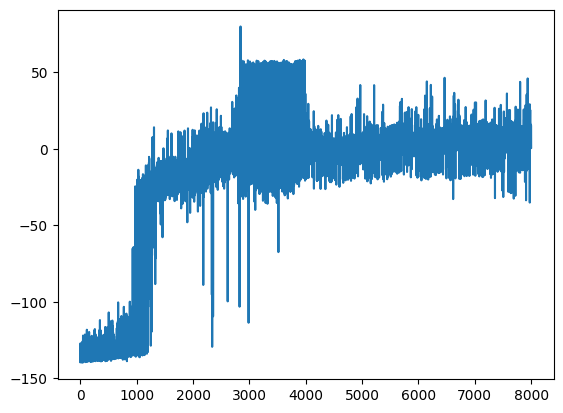

In [ ]:
env = CustomRewardEnv_2(gym.make("MountainCar-v0")) #środowisko z nową funkcją nagrody
#env = gym.make("MountainCar-v0") # środowisko z domyślną nagrodą
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"state dim: {state_dim}")
print(f"action dim: {action_dim}")

q_net = QNetwork(state_dim, action_dim).to(device)
#q_net.load_state_dict(torch.load("dqn_car_default_0k-3k.pth")) # ładowanie modelu w celu ewentualnego dotrenowania
target_net = QNetwork(state_dim, action_dim).to(device)
target_net.load_state_dict(q_net.state_dict())

buffer = ReplayBuffer(10000)

rewards = fit(env, q_net, target_net, buffer, episodes=8000, epsilon_start=1, epsilon_end=0.001, lr=1e-4, target_update=300, epsilon_decay=0.999)

torch.save(q_net.state_dict(), "dqn_car_custom2_bigger_0k-8k.pth")

with open("rewards_custom2_bigger_0k-8k.txt", "w") as f:
    for item in rewards:
        f.write(f"{item}\n")
plt.plot(rewards)

In [ ]:

env = CustomRewardEnv_2(gym.make("MountainCar-v0"))
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_net = QNetwork(state_dim, action_dim).to(device)
q_net.load_state_dict(torch.load("dqn_car_custom_6k-8k.pth"))
q_net.eval() 


QNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [ ]:
import imageio
import gymnasium as gym
import numpy as np

def generate_gif(env, q_net, filename="dqn_custom_3k.gif", episodes=1):
    frames = []
    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = q_net(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frame = env.render() 
            frames.append(frame)

            state = next_state

    env.close()

    # Zapisuje gif 
    imageio.imwrite(filename, frames[0])
    imageio.mimsave(filename, frames, fps=30)


In [9]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
#env = CustomRewardEnv(env)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_net = QNetwork(state_dim, action_dim).to(device)
q_net.load_state_dict(torch.load("dqn_car_custom2_bigger_0k-8k.pth"))
generate_gif(env, q_net, filename="car_custom2_bigger_8k.gif")


In [ ]:
import torch
import gymnasium as gym

def evaluate_model(model, episodes=100, render=False): # tutaj agent rozgrywa gry z których podsumowujemy jego performance
    env = gym.make("MountainCar-v0", render_mode="rgb_array" if render else None)
    env = CustomRewardEnv_2(env) 

    step_counts = []

    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            steps += 1

        step_counts.append(steps)

    env.close()
    return step_counts


In [11]:
steps_custom2 = evaluate_model(model=q_net)
percent = (np.sum(np.array([1 if n_step < 200 else 0 for n_step in steps_custom2]))/len(steps_custom2))*100
print(np.mean(np.array(steps_custom2)), percent)

134.67 88.0


(array([14.,  7.,  3.,  1.,  8., 47.,  1., 12.,  5.,  2.]),
 array([ 85. ,  96.4, 107.8, 119.2, 130.6, 142. , 153.4, 164.8, 176.2,
        187.6, 199. ]),
 <BarContainer object of 10 artists>)

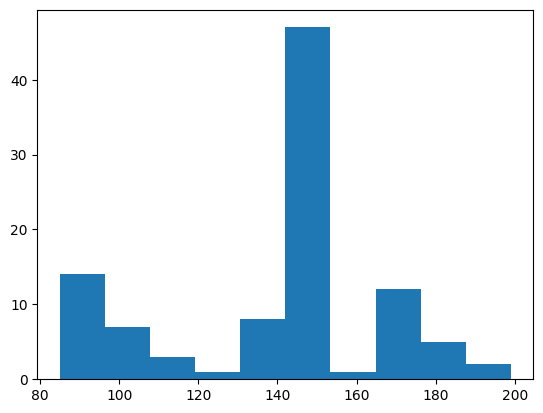

In [12]:
plt.hist(steps_custom2)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Sklejanie wcześniej zapisywanych nagród z trenowania i tworzenie wykresów

In [2]:
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_default\\rewards_default_0k-6k.txt", 'r', encoding='utf-8') as file:
    rewards_1 = [line.strip() for line in file]
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_default\\rewards_default_6k-8k.txt", 'r', encoding='utf-8') as file:
    rewards_2 = [line.strip() for line in file]
rewards = rewards_1 + rewards_2 

len(rewards)

8000

C:\Users\User\AppData\Local\Temp\ipykernel_19208\3482420617.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


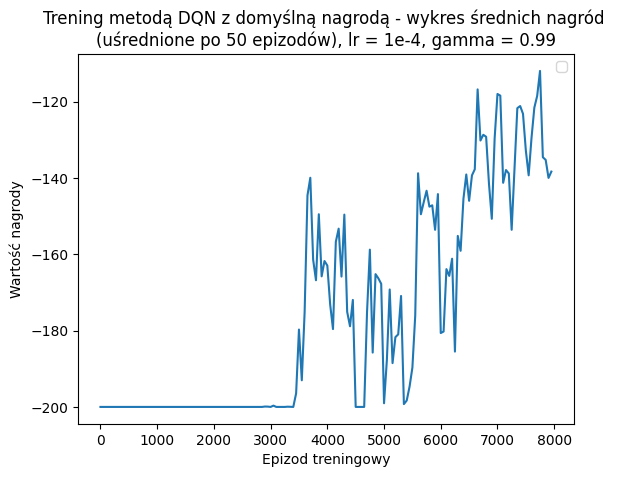

In [3]:
rewards = [float(x) for x in rewards]
mean_rewards = [np.mean(np.array(rewards[50*i:50*(i+1)])) for i in range(int(len(rewards)/50))]

domain = list(range(0, 8000, 50))
plt.plot(domain, mean_rewards)
plt.title("Trening metodą DQN z domyślną nagrodą - wykres średnich nagród \n(uśrednione po 50 epizodów), lr = 1e-4, gamma = 0.99")
plt.xlabel('Epizod treningowy')
plt.ylabel('Wartość nagrody')
plt.legend()
plt.savefig(f"C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_default\\Mean_reward_car_default.png")
plt.show()

In [4]:
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_1\\rewards_custom_3k.txt", 'r', encoding='utf-8') as file:
    rewards_1 = [line.strip() for line in file]
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_1\\rewards_custom_3k-6k.txt", 'r', encoding='utf-8') as file:
    rewards_2 = [line.strip() for line in file]
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_1\\rewards_custom_6k-8k.txt", 'r', encoding='utf-8') as file:
    rewards_3 = [line.strip() for line in file] 
rewards = rewards_1 + rewards_2 + rewards_3

len(rewards)

8000

C:\Users\User\AppData\Local\Temp\ipykernel_19208\1387479707.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


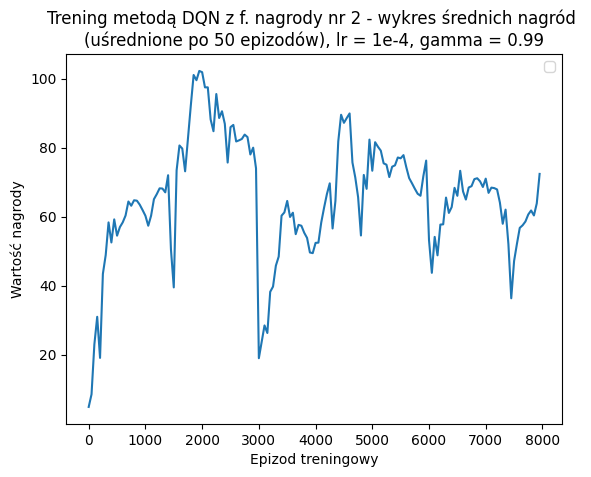

In [5]:
rewards = [float(x) for x in rewards]
mean_rewards = [np.mean(np.array(rewards[50*i:50*(i+1)])) for i in range(int(len(rewards)/50))]

domain = list(range(0, 8000, 50))
plt.plot(domain, mean_rewards)
plt.title("Trening metodą DQN z f. nagrody nr 2 - wykres średnich nagród \n(uśrednione po 50 epizodów), lr = 1e-4, gamma = 0.99")
plt.xlabel('Epizod treningowy')
plt.ylabel('Wartość nagrody')
plt.legend()
plt.savefig(f"C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_1\\Mean_reward_car_custom1.png")
plt.show()

In [6]:
with open("C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_2\\rewards_custom2_0k-3k.txt", 'r', encoding='utf-8') as file:
    rewards = [line.strip() for line in file]
len(rewards)

3000

C:\Users\User\AppData\Local\Temp\ipykernel_19208\2449291023.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


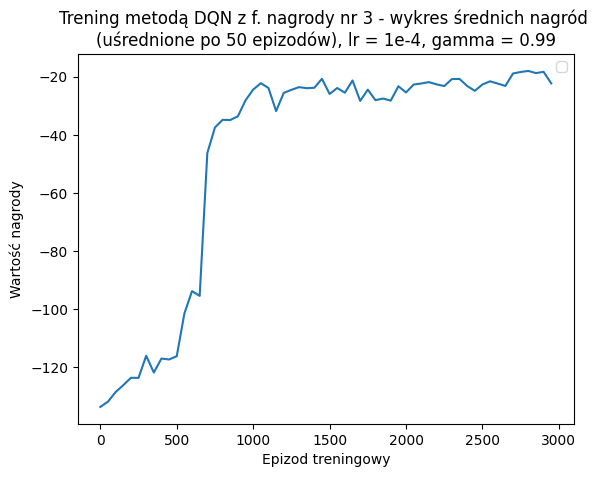

In [7]:
rewards = [float(x) for x in rewards]
mean_rewards = [np.mean(np.array(rewards[50*i:50*(i+1)])) for i in range(int(len(rewards)/50))]

domain = list(range(0, 3000, 50))
plt.plot(domain, mean_rewards)
plt.title("Trening metodą DQN z f. nagrody nr 3 - wykres średnich nagród \n(uśrednione po 50 epizodów), lr = 1e-4, gamma = 0.99")
plt.xlabel('Epizod treningowy')
plt.ylabel('Wartość nagrody')
plt.legend()
plt.savefig(f"C:\\Users\\User\\Desktop\\magisterka_kod\\ML\\modele_RL\\car_custom_2\\Mean_reward_car_custom2.png")
plt.show()